In [16]:
# Imports
from src.utils import import_from_json
from pathlib import Path
from typing import Sequence, List, Dict, Union, Any, Tuple

from model.enums import ElementType, Direction, FailureType
from src.subassembly import flip_direction
from model.validation import Regular2DFrameInput, BasicSectionCollectionInput, SimpleMaterialInput


import matplotlib.pyplot as plt


from src.concrete import Concrete
from src.steel import Steel
from src.scripts import convert_to_section_collection
from src.sections.basic_section import BasicSection
from src.elements.basic_element import BasicElement
from src.frame import RegularFrameBuilder
from src.subassembly import SubassemblyFactory

from src.capacity import mixed_sidesway, beam_sidesway, column_sidesway

from model.enums import Direction, FailureType
from src.subassembly import Subassembly, flip_direction

import numpy as np
from model.enums import Direction
from src.subassembly import flip_direction

In [17]:
FRAME_INPUT_PATH: Path = Path('./Inputs/Frame.json')
SECTIONS_INPUT_PATH: Path = Path('./Inputs/Sections.json')
MATERIALS_INPUT_PATH: Path = Path('./Inputs/Materials.json')

# Set up SLaMA

Import and validate input files

In [18]:

# Import frame data
frame_dct = import_from_json(FRAME_INPUT_PATH)
# print(frame_dct)
# Validate frame data
validated_frame = Regular2DFrameInput(
    **frame_dct
)
# Import section data
sections_dct = import_from_json(SECTIONS_INPUT_PATH)
# validate section data
validated_sections = BasicSectionCollectionInput(
    **sections_dct
)
# Import material data
materials_dct = import_from_json(MATERIALS_INPUT_PATH)
# Validate material data
validated_materials = SimpleMaterialInput(
    **materials_dct
)

Build the model

In [19]:


# Instansiate material objects
steel = Steel(**validated_materials.steel.__dict__)
concrete = Concrete(**validated_materials.concrete.__dict__)
# Instanciate Section Data and visitors
sections = convert_to_section_collection(
    validated_sections,
    concrete,
    steel,
    section_type=BasicSection
)
# Build frame model
frame_builder = RegularFrameBuilder(
    frame_data=validated_frame,
    sections=sections,
    element_object=BasicElement
)
frame_builder.build_frame()
frame = frame_builder.get_frame()
# Get subassemblies
subassemly_factory = SubassemblyFactory(frame=frame)

# Capacity Curves

In [20]:


# Compute capacity
beam_SLaMA = beam_sidesway(
    sub_factory=subassemly_factory,
    frame=frame
)
column_SLaMA = column_sidesway(
    sub_factory=subassemly_factory,
    frame=frame
)
classic_SLaMA = mixed_sidesway(
    sub_factory=subassemly_factory,
    frame=frame
)

C:\Users\michele.matteoni\AppData\Local\Temp\ipykernel_43316\905597588.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


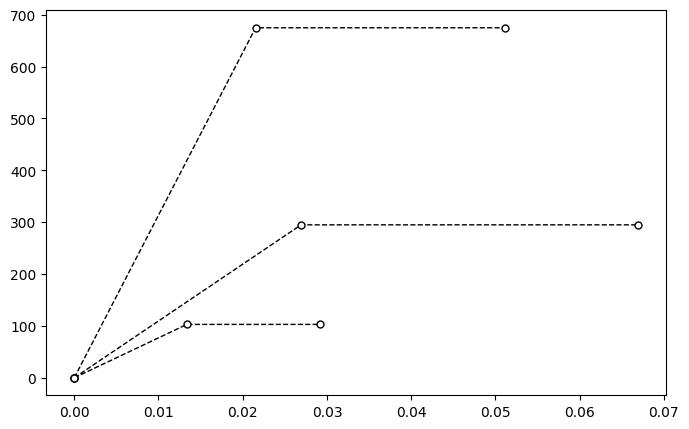

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

linestyle = {
    'linestyle': '--',
    'linewidth': 1,
    'marker': 'o',
    'markersize': 5,
    'mfc': 'white'
}


# Column_sway
ax.plot(
    [0,] + column_SLaMA.disp,
    [0,] + column_SLaMA.base_shear,
    label=column_SLaMA.name,
    color='k',
    **linestyle
)
#   Beam_sway
ax.plot(
    [0,] + beam_SLaMA.disp,
    [0,] + beam_SLaMA.base_shear,
    label=beam_SLaMA.name,
    color='k',
    **linestyle
)
# Column_sway
ax.plot(
    [0,] + classic_SLaMA.disp,
    [0,] + classic_SLaMA.base_shear,
    label=classic_SLaMA.name,
    color='k',
    **linestyle
)

fig.show()


# Mechanism

In [22]:
from model.enums import ElementType
from model.enums import FailureType


FRAME_COLOR: str = 'k'

OFFSET: float = .5
LABEL_SIZE: int = 9
PADDING: float = 5

# Markers
MARKER_SIZE: int = 7

MOMENT_BEAMCOLUMN_MARKER = {
    'marker': 'o',
    'mfc': 'b',
    'mec': 'b'
}
SHEAR_BEAMCOLUMN_MARKER = {
    'marker': 'D',
    'mfc': 'b',
    'mec': 'b'
}
FRAGILE_BEAMCOLUMN_MARKER = {
    'marker': 'X',
    'mfc': 'r',
    'mec': 'r'
}

JOINT_MARKER = {
    'marker': 's',
    'mfc': 'r',
    'mec': 'r'
}

ELEMENT_MARKERS: Dict[FailureType, Dict] = {
    FailureType.Moment: MOMENT_BEAMCOLUMN_MARKER,
    FailureType.ShearDuctile: SHEAR_BEAMCOLUMN_MARKER,
    FailureType.ShearFragile: FRAGILE_BEAMCOLUMN_MARKER
}


Offset computation functions

In [23]:
# Marker Offsets
def offset_columns(x, y) -> Tuple[Sequence[float], Sequence[float]]:
    return [x] * 2, [y - OFFSET, y + OFFSET]

def offset_abovecolumn(x, y) -> Tuple[Sequence[float], Sequence[float]]:
    return [x], [y + OFFSET]

def offset_belowcolumn(x, y) -> Tuple[Sequence[float], Sequence[float]]:
    return [x], [y - OFFSET]

def offset_beams(x, y) -> Tuple[Sequence[float], Sequence[float]]:
    return [x - OFFSET, x + OFFSET] , [y] * 2

def offset_rightbeam(x, y) -> Tuple[Sequence[float], Sequence[float]]:
    return [x + OFFSET], [y]

def offset_leftbeam(x, y) -> Tuple[Sequence[float], Sequence[float]]:
    return [x - OFFSET], [y]

def offset_joint(x, y) -> Tuple[Sequence[float], Sequence[float]]:
    return [x], [y]
    
offset_mapping = {
    ElementType.AboveColumn: offset_abovecolumn,
    ElementType.BelowColumn: offset_belowcolumn,
    ElementType.Column: offset_columns,
    ElementType.LeftBeam: offset_leftbeam,
    ElementType.RightBeam: offset_rightbeam,
    ElementType.Beam: offset_beams,
    ElementType.Joint: offset_joint
}

In [24]:



def get_failure_type(subassembly: Subassembly, 
                     weakest: ElementType, 
                     direction: Direction = Direction.Positive) -> FailureType:
    counter_direction = flip_direction(direction)
    if weakest == ElementType.Beam:
        beam_failures = []
        if subassembly.left_beam is not None:
            beam_failures.append(
                get_failure_type(
                    subassembly, 
                    ElementType.LeftBeam, 
                    direction
                )
            )
        if subassembly.right_beam is not None:
            beam_failures.append(
                get_failure_type(
                    subassembly, 
                    ElementType.RightBeam, 
                    direction
                )
            )
        return min(beam_failures)
    
    if weakest == ElementType.Column:
        column_failures = []
        if subassembly.above_column is not None:
            column_failures.append(
                get_failure_type(
                    subassembly, 
                    ElementType.AboveColumn, 
                    direction
                )
            )
        if subassembly.below_column is not None:
            column_failures.append(
                get_failure_type(
                    subassembly, 
                    ElementType.BelowColumn, 
                    direction
                )
            )
        return min(column_failures)

    if weakest == ElementType.LeftBeam:
        left_beam = subassembly.left_beam
        assert left_beam is not None
        return left_beam.moment_rotation(counter_direction).failure
    if weakest == ElementType.RightBeam:
        right_beam = subassembly.right_beam
        assert right_beam is not None
        return right_beam.moment_rotation(direction).failure
    
    if weakest == ElementType.AboveColumn:
        above_column = subassembly.above_column
        assert above_column is not None
        return above_column.moment_rotation(direction, axial=subassembly.axial).failure
    if weakest == ElementType.RightBeam:
        below_column = subassembly.below_column
        assert below_column is not None
        return below_column.moment_rotation(direction, axial=subassembly.axial).failure
    
    return FailureType.Moment
    

(0.0, 14.0)

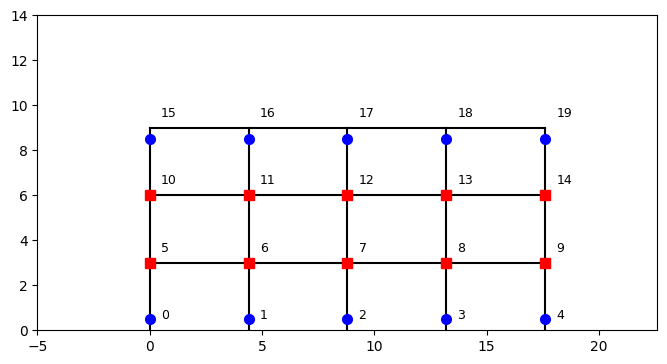

In [25]:
# options
SHOW_TEXT: bool = True

frame_lengths = frame._lengths
frame_heights = frame._heights

fig, ax = plt.subplots(figsize=(8, 8 * frame_heights[-1]/frame_lengths[-1]))

# Columns
for vertical in frame_lengths:
    ax.plot(
        [vertical] * 2,
        [0,] + frame_heights[-1:],
        color=FRAME_COLOR
    )

# Beams
for height in frame_heights:
    ax.plot(
        [0,] + frame_lengths[-1:],
        [height] * 2,
        color=FRAME_COLOR
    )

# Base columns
for i, vertical in enumerate(frame_lengths):
    failure = get_failure_type(
        subassembly=subassemly_factory.get_subassembly(i),
        weakest=ElementType.AboveColumn
    )
    ax.plot(
        *offset_mapping[ElementType.AboveColumn](vertical, 0),
        linestyle='',
        markersize=MARKER_SIZE,
        **ELEMENT_MARKERS[failure]
    )

# All other subassemblies
for i in range(frame.verticals, frame.get_node_count()):
    x, y = frame.get_node_coordinates(i)
    # Get mechanism
    sub_hierarchy = subassemly_factory.get_subassembly(i).get_hierarchy()
    weakest = sub_hierarchy.weakest
    
    if weakest == ElementType.Joint:
        ax.plot(
            *offset_mapping[weakest](x, y),
            linestyle='',
            markersize=MARKER_SIZE,
            **JOINT_MARKER
        )
        continue

    # Overrides last floor
    if frame.get_node_floor(i) == frame.floors and (weakest is ElementType.Column):
        weakest = ElementType.BelowColumn

    # Overrides first column
    if frame.get_node_vertical(i) == 0 and (weakest is ElementType.Beam):
        weakest = ElementType.RightBeam

    # Overrides last column
    if frame.get_node_vertical(i) == (frame.verticals - 1) and (weakest is ElementType.Beam):
        weakest = ElementType.LeftBeam

    failure = get_failure_type(
        subassembly=subassemly_factory.get_subassembly(i),
        weakest=weakest
    )
    assert failure is not None
    ax.plot(
        *offset_mapping[weakest](x, y),
        linestyle='',
        markersize=MARKER_SIZE,
        **ELEMENT_MARKERS[failure]
    )

# Labels
if SHOW_TEXT:
    for i in range(frame.get_node_count()):
        x, y = frame.get_node_coordinates(i) 
        ax.text(
            x + OFFSET,
            y + OFFSET,
            str(i),
            fontsize=LABEL_SIZE
        )

# Settings
ax.set_xlim(-PADDING, frame_lengths[-1] + PADDING)
ax.set_ylim(0, frame_heights[-1] + PADDING)


Rotations

(0.0, 14.0)

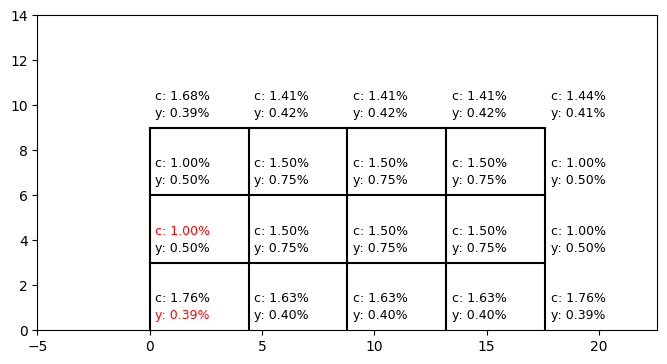

In [26]:
from model.enums import Direction


fig, ax = plt.subplots(figsize=(8, 8 * frame_heights[-1]/frame_lengths[-1]))


# Columns
for vertical in frame_lengths:
    ax.plot(
        [vertical] * 2,
        [0,] + frame_heights[-1:],
        color=FRAME_COLOR
    )

# Beams
for height in frame_heights:
    ax.plot(
        [0,] + frame_lengths[-1:],
        [height] * 2,
        color=FRAME_COLOR
    )

# find lowest
min_y = 10
yielding_sub = 0
min_c = 10
capacity_sub = 0
for i in range(frame.verticals):
    subassembly = subassemly_factory.get_subassembly(i)
    column = subassembly.above_column
    assert column is not None
    mom_rot = column.moment_rotation(Direction.Positive, subassembly.axial)

    if min_y > mom_rot.rot_y:
        min_y = mom_rot.rot_y
        yielding_sub = i
    if min_c > mom_rot.rot_c:
        min_c = mom_rot.rot_c
        capacity_sub = i

for i in range(frame.verticals, frame.get_node_count()):
    hierarchy = subassemly_factory.get_subassembly(i).get_hierarchy()

    if min_y > hierarchy.rot_y:
        min_y = hierarchy.rot_y
        yielding_sub = i
    if min_c > hierarchy.rot_c:
        min_c = hierarchy.rot_c
        capacity_sub = i

# Labels
for i in range(frame.verticals, frame.get_node_count()):
    sub_hierarchy = subassemly_factory.get_subassembly(i).get_hierarchy()
    x, y = frame.get_node_coordinates(i) 
    
    # Yielding
    color_y = 'k'
    if i == yielding_sub:
        color_y = 'r'
    ax.text(
        x + .5 * OFFSET,
        y + OFFSET,
        f'y: {sub_hierarchy.rot_y*100:.2f}%',
        fontsize=LABEL_SIZE,
        color=color_y
    )
    
    # Capping
    color_c = 'k'
    if i == capacity_sub:
        color_c = 'r'
    ax.text(
        x + .5 * OFFSET,
        y + 2.5 * OFFSET,
        f'c: {sub_hierarchy.rot_c*100:.2f}%',
        fontsize=LABEL_SIZE,
        color=color_c
    )

# Base columns
for i in range(frame.verticals):
    column = subassemly_factory.get_subassembly(i).above_column
    assert column is not None
    capacity = column.moment_rotation(Direction.Positive)
                    
    x, y = frame.get_node_coordinates(i) 
    # Yielding
    color_y = 'k'
    if i == yielding_sub:
        color_y = 'r'
    ax.text(
        x + .5 * OFFSET,
        y + OFFSET,
        f'y: {capacity.rot_y*100:.2f}%',
        fontsize=LABEL_SIZE,
        color=color_y
    )
    # Capping
    color_c = 'k'
    if i == capacity_sub:
        color_c = 'r'
    ax.text(
        x + .5 * OFFSET,
        y + 2.5 * OFFSET,
        f'c: {capacity.rot_c*100:.2f}%',
        fontsize=LABEL_SIZE,
        color=color_c
    )

# Settings
ax.set_xlim(-PADDING, frame_lengths[-1] + PADDING)
ax.set_ylim(0, frame_heights[-1] + PADDING)

Overturning Moment

(0.0, 14.0)

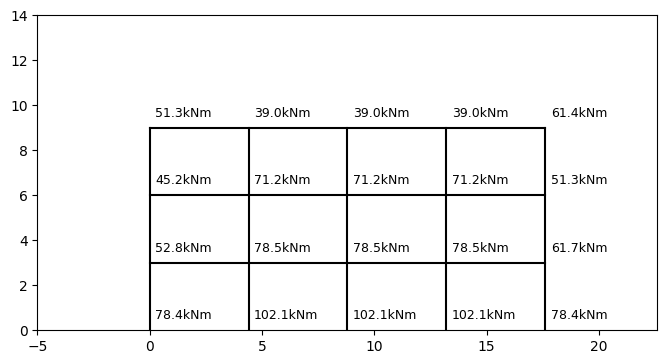

In [27]:
fig, ax = plt.subplots(figsize=(8, 8 * frame_heights[-1]/frame_lengths[-1]))


# Columns
for vertical in frame_lengths:
    ax.plot(
        [vertical] * 2,
        [0,] + frame_heights[-1:],
        color=FRAME_COLOR
    )

# Beams
for height in frame_heights:
    ax.plot(
        [0,] + frame_lengths[-1:],
        [height] * 2,
        color=FRAME_COLOR
    )

for i in range(frame.verticals, frame.get_node_count()):
    sub_hierarchy = subassemly_factory.get_subassembly(i).get_hierarchy()
    x, y = frame.get_node_coordinates(i) 
    # Yielding
    ax.text(
        x + .5 * OFFSET,
        y + OFFSET,
        f'{sub_hierarchy.beam_eq:.1f}kNm',
        fontsize=LABEL_SIZE
    )

for i in range(frame.verticals):
    column = subassemly_factory.get_subassembly(i).above_column
    assert column is not None
    capacity = column.moment_rotation(Direction.Positive, axial=subassemly_factory.get_subassembly(i).axial)
                    
    x, y = frame.get_node_coordinates(i) 
    # Yielding
    ax.text(
        x + .5 * OFFSET,
        y + OFFSET,
        f'{capacity.mom_c:.1f}kNm',
        fontsize=LABEL_SIZE
    )

# Settings
ax.set_xlim(-PADDING, frame_lengths[-1] + PADDING)
ax.set_ylim(0, frame_heights[-1] + PADDING)

# Subassembly hierarchy

Average and total hierarchy

Text(0.5, 1.0, 'Node: 7')

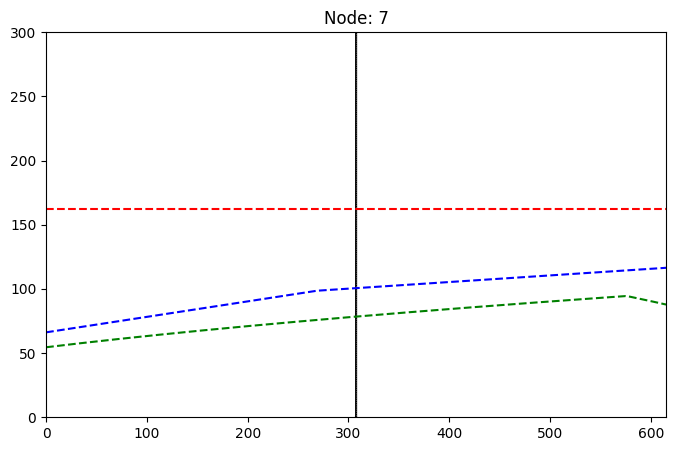

In [28]:


SUBASSEMBLY: int = 7

# Options
N_COUNT: int = 100

# Get the subassembly
subassembly = subassemly_factory.get_subassembly(SUBASSEMBLY)

is_last_vertical = frame.get_node_vertical(SUBASSEMBLY) == (frame.verticals - 1)

# Topology
columns_number = (subassembly.above_column is not None) + 1
beam_number = (subassembly.left_beam is not None) + (subassembly.right_beam is not None)
conversion_factor = beam_number / columns_number

# In total we use the sum of the elements
def _beam_capacity(_: float, direction: Direction) -> float:
    counter_direction = flip_direction(direction)
    return 1/columns_number * sum(
        [
            subassembly.left_beam.moment_rotation(counter_direction).mom_c
                if subassembly.left_beam is not None else 0,
            subassembly.right_beam.moment_rotation(direction).mom_c
                if subassembly.right_beam is not None else 0
        ]
    )

def _column_capacity(axial: float) -> float:
    return 1/columns_number * sum(
        [
            subassembly.above_column.get_section().domain_MN(axial)
                if subassembly.above_column is not None else 0,
            subassembly.below_column.get_section().domain_MN(axial)
                if subassembly.below_column is not None else 0,
        ]
    )


# Plotting
max_axial = subassembly.axial * 2

# Figure plot
fig, ax = plt.subplots(figsize=(8, 5))
axial_upwind = np.linspace(0, subassembly.axial, N_COUNT)
axial_downwind = np.linspace(subassembly.axial, max_axial, N_COUNT)
axial_all = np.linspace(0, max_axial, 2 * N_COUNT)

# Delta axial
# downwind
downwind_direction = Direction.Negative if not is_last_vertical else Direction.Positive
ax.plot(
    axial_downwind,
    [subassembly.delta_axial_moment(n, downwind_direction) 
     for n in axial_downwind],
    color='k'
)
# upwind
upwind_direction = flip_direction(downwind_direction)
ax.plot(
    axial_upwind,
    [subassembly.delta_axial_moment(n, upwind_direction) 
     for n in axial_upwind],
    color='k'
)
# central
upwind_direction = flip_direction(downwind_direction)
ax.plot(
    [subassembly.axial] * 2,
    [0, 1e4],
    color='gray',
    linewidth=0.5,
    linestyle='dotted'
)

# Columns
ax.plot(
    axial_all,
    [_column_capacity(n) for n in axial_all],
    color='b',
    linestyle='--',
    label='Columns'
)

# Joint
ax.plot(
    axial_all,
    [subassembly.domain_MN(n) for n in axial_all],
    color='g',
    linestyle='--',
    label='Joint'
)

# Beams
# downwind
ax.plot(
    [axial_downwind[0], axial_downwind[-1]],
    [_beam_capacity(0, direction=downwind_direction)] * 2,
    color='r',
    linestyle='--',
    label='Beams Negative'
)
# upwind
ax.plot(
    [axial_upwind[0], axial_upwind[-1]],
    [_beam_capacity(0, direction=upwind_direction)] * 2,
    color='r',
    linestyle='--',
    label='Beams Positive'
)

# Visualize
MAX_M = 300

ax.set_ylim(0, MAX_M)
ax.set_xlim(0, max_axial)
ax.set_title(f'Node: {SUBASSEMBLY}')


# Elements

In [29]:
from typing import Set


COLUMNS: Set[ElementType] = {
    ElementType.Column,
    ElementType.AboveColumn,
    ElementType.BelowColumn
}

BEAMS: Set[ElementType] = {
    ElementType.Beam,
    ElementType.LeftBeam,
    ElementType.RightBeam
}


        BasicSection Object
        section id      : Beam_Main
        h               : 0.5
        b               : 0.3
        cover           : 0.03
        As              : 0.0003078760800517998
        As1             : 0.0016305731914277796
        eq_bar_diameter : 0.016
        s               : 0.15
         243.03
0.004123168535430694


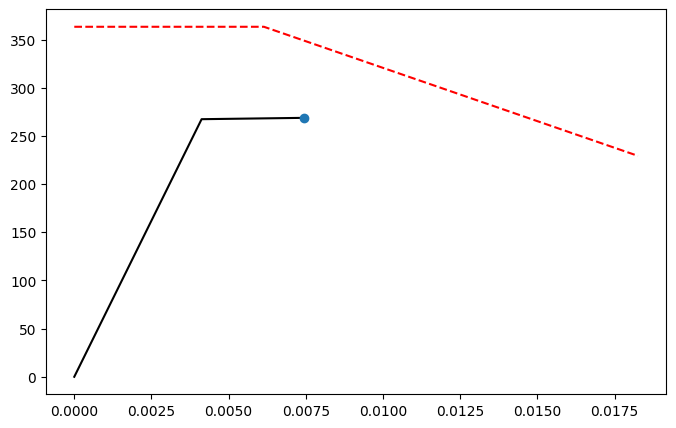

In [30]:
SUBASSEMBLY: int = 9

ELEMENT: ElementType = ElementType.LeftBeam
DIRECTION: Direction = Direction.Positive

# Code
subassembly = subassemly_factory.get_subassembly(SUBASSEMBLY)
direction = DIRECTION if ELEMENT is not ElementType.LeftBeam else flip_direction(DIRECTION)
element = subassembly.get_element(ELEMENT)

assert element is not None, AssertionError(f'Subassembly {i} does not have an element {ELEMENT}')

axial = 0 if ELEMENT in BEAMS else subassembly.axial

element_section = element.get_section()
element_length = element.get_element_lenght()

shear_capacity = element_section.shear_capacity(element.get_element_lenght(), axial)
mom_rot = element.moment_rotation(direction, consider_shear_iteraction=False, axial=axial)

mom_rot_shear = element.moment_rotation(direction, axial=axial)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    [0, mom_rot.rot_y, mom_rot.rot_c],
    [0, mom_rot.mom_y, mom_rot.mom_c],
    color='k'
)

p_hinge = element.get_plastic_hinge_lenght()
mom_curv = element_section.moment_curvature(direction)
# Compute the evelope in terms of moment-rotation
shear_moment_cap_undamaged = shear_capacity.cap_undamaged * element_length/2
shear_moment_cap_residual = shear_capacity.cap_residual * element_length/2
shear_rotation_undamaged = mom_rot.rot_y + (shear_capacity.duc_undamaged - 1) * p_hinge * mom_curv.phi_y
shear_rotation_residual = mom_rot.rot_y + (shear_capacity.duc_residual - 1) * p_hinge * mom_curv.phi_y


ax.plot(
    [0, 
    shear_rotation_undamaged,
     shear_rotation_residual,
     max(shear_rotation_residual, mom_rot.rot_c)],
    [shear_moment_cap_undamaged] * 2 \
        + [shear_moment_cap_residual] * 2,
    color='red',
    linestyle='--'
)

ax.plot(
    [mom_rot_shear.rot_c],
    [mom_rot_shear.mom_c],
    linestyle='',
    marker='o'
)

print(element_section, subassembly.axial)
print(mom_rot.rot_y)
